# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

1. [Introduction](#intro)<br>
2. [Load & clean dataset](#wrangling)<br>
3. [Exploratory data analysis](#eda)<br>
4. [Feature engineering](#feateng)<br>
5. [Modeling](#model)<br>
6. [Conclusion](#results)<br>


# <a class="anchor" id="intro">1. Introduction</a>

Along this project, we will be working on a challenging real case problem that many customer-facing business have to deal with, which is how to predict the churn rate of their users.

To accomplish the project, we have been provided with a datastet from Sparkify organization.

We will be working on large dataset hence usage of Spark will be key to manipulate the data. Spark ML lib will also be deterministic in the best choice of algorithm to pick and evaluate for our predictive model.


In [106]:
# import libraries
import datetime
import time
import pyspark
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession


from pyspark.sql.functions import col,isnan, when, count,lower,udf, datediff,countDistinct
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType



from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("SparkifyProject") \
    .getOrCreate()

# <a class="anchor" id="wrangling">2. Load & clean dataset</a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
# check for schema data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# shape of dataset
print((df.count(), len(df.columns)))

(286500, 18)


In [7]:
# check for empty/null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



`.` We have some nan/null values that we'll have to take care of before building our model.
Those empty values can not be dropped arbitrarily in our case since they might be expected for some of the events logged in data.

In [8]:
# checking for duplicates rows cross all cols
df.exceptAll(df.dropDuplicates(df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# check num of rows after removing dups 
print((df.count(), len(df.columns)))

(286500, 18)


`.` no duplicate row found checking for all cols in dataset

In [10]:
# lower case all col names
df_clean = df.select([F.col(x).alias(x.lower()) for x in df.columns])

In [11]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- iteminsession: long (nullable = true)
 |-- lastname: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionid: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- useragent: string (nullable = true)
 |-- userid: string (nullable = true)



In [12]:
# removing userID set as empty string
df_clean = df_clean.filter(df_clean["userid"] != "")


`.` We had some rows storing userid as empty string. This would break some operations carried out later and such records do not bring
any value, therefore we can safely remove those.

In [13]:
# Define udf to convert epoch timestamp to human readable date format
convert_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [14]:
# create new col event_timedate
df_clean = df_clean.withColumn("event_timedate", convert_datetime(df_clean.ts))

# create new col registration_date
df_clean = df_clean.withColumn("registration_timedate", convert_datetime(df_clean.registration))

In [15]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- iteminsession: long (nullable = true)
 |-- lastname: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionid: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- useragent: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- event_timedate: string (nullable = true)
 |-- registration_timedate: string (nullable = true)



`.` new columns created properly showing up in schema

In [16]:
# cast data type to sort our data
df_clean = df_clean.withColumn("userid",df_clean.userid.cast(IntegerType()))
df_clean = df_clean.withColumn("ts",df_clean.ts.cast(IntegerType()))


In [17]:
# sort events by user and time
df_clean = df_clean.sort(['userid','ts'], ascending=True)

# check is events are sorted properly
df_clean.filter(df_clean["userid"] == 30).toPandas().head()

,artist,auth,firstname,gender,iteminsession,lastname,length,level,location,method,page,registration,sessionid,song,status,ts,useragent,userid,event_timedate,registration_timedate
0,None,Logged In,Colin,M,2,Freeman,NaN,free,"Bakersfield, CA",GET,Home,1538173362000,945,None,200,-1822290264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-20 21:29:29,2018-09-28 22:22:42
1,Carbon Based Lifeforms,Logged In,Colin,M,0,Freeman,425.27302,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,Silent Running,200,-1625175264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:14:44,2018-09-28 22:22:42
2,Metallica,Logged In,Colin,M,1,Freeman,396.40771,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,The Unforgiven II,200,-1624750264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:21:49,2018-09-28 22:22:42
3,Les MisÃÂ©rables - 10th Anniversary Concert,Logged In,Colin,M,2,Freeman,219.92444,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,Valjean's Soliloquy,200,-1624354264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:28:25,2018-09-28 22:22:42
4,FM Static,Logged In,Colin,M,3,Freeman,218.27873,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,Tonight,200,-1624135264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:32:04,2018-09-28 22:22:42


`.` We are sorting all users interactions in chronological order (asc). let's see if we can later extract some feature out of it. Having the ordered sequences of actions performed might help us to identify possible pain points churn users came across.

# <a class="anchor" id="eda">3. Exploratory data analysis</a>



When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
# identify churned users
churn_ids = df_clean.select("userid").where(df_clean.page =="Cancellation Confirmation")

churn_ids_list = churn_ids.select("userid").rdd.flatMap(lambda x: x).collect()

In [19]:
# add new col to identify actions made by churned/not churned users
df_clean = df_clean.withColumn("has_cancelled",when((df_clean.userid.isin(churn_ids_list)), 1).otherwise(0))

In [20]:
# check for num of churned users
df_clean.groupBy("has_cancelled").agg(countDistinct('userid')).show()

+-------------+----------------------+
|has_cancelled|count(DISTINCT userid)|
+-------------+----------------------+
|            1|                    52|
|            0|                   173|
+-------------+----------------------+



`.` all rows/interactions made to churned users will return `has_cancelled ==1`

`.` we only have 52 users who churned, even thought they count for 30% of our users base, this number might be too small, let's also consider to add users who downgraded.

In [21]:
# identify users who downgraded
downgrade_ids = df_clean.select("userid").where(df_clean.page =="Downgrade")

downgrade_ids_list = downgrade_ids.select("userid").rdd.flatMap(lambda x: x).collect()

In [22]:
# add downgraded users col to dataset

df_clean = df_clean.withColumn("has_downgraded",when((df_clean.userid.isin(downgrade_ids_list)), 1).otherwise(0))

In [23]:
# check for num of downgraded users
df_clean.groupBy("has_downgraded").agg(countDistinct('userid')).show()

+--------------+----------------------+
|has_downgraded|count(DISTINCT userid)|
+--------------+----------------------+
|             1|                   154|
|             0|                    71|
+--------------+----------------------+



`.` all rows/interactions made to users who downgraded will return `has_downgraded ==1`

`.` it will be interesting to look at if users who churned did downgrade before. It might be a sign user is about to leave.


In [24]:
# Descriptive statistics for numerical variables
df_clean.select([col[0] for col in df_clean.dtypes if col[1] != 'string']).toPandas().describe()

,iteminsession,length,registration,sessionid,status,ts,userid,has_cancelled,has_downgraded
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000,278154.000000,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,2.021887e+08,59682.022786,0.161292,0.937308
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.252569e+09,109091.949999,0.367801,0.242408
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,-2.147464e+09,2.000000,0.000000,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,-8.892365e+08,51.000000,0.000000,1.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,4.292007e+08,98.000000,0.000000,1.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.329670e+09,100004.000000,0.000000,1.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,2.147455e+09,300025.000000,1.000000,1.000000


`.` we don't have too many insightful numerical variables.

`.` `iteminsession` since its attached to sessionid, counter probably resets for every new session (i.e cold-start problem?)

`.` `length` being the time (secs) a song was played.

`.` other vars are not being of interest for our model, we will have to make sure to do some feature engineering work

In [25]:
# create view 'sparkify_users_interactions_churn' to use sql
df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

### `1.` Overall churn rate

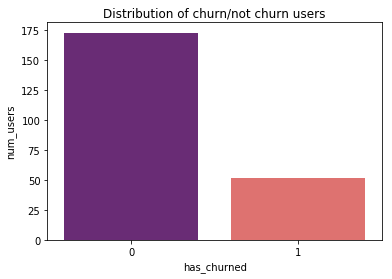

Churn rate in dataset is 23%


In [26]:
q1 = spark.sql('''
        SELECT has_cancelled as has_churned
                ,count(distinct userid) as num_users
        FROM sparkify_users_interactions_churn

     group by 1

''').toPandas()


sns.barplot(x = 'has_churned',y='num_users', data = q1, palette = 'magma')
plt.title('Distribution of churn/not churn users')
plt.show()


# compute churn rate
churn_rate = q1.loc[q1['has_churned']==1, 'num_users'].sum()/ q1.num_users.sum()

print("Churn rate in dataset is","{:.0%}".format(churn_rate))



`.` with a churn rate of 23% one can consider we are dealing with an unbalanced class. it might have an impact during for the evaluation of our model, f1 will have to be computed and balance with accuracy score.

### `2.` Churn rate by gender


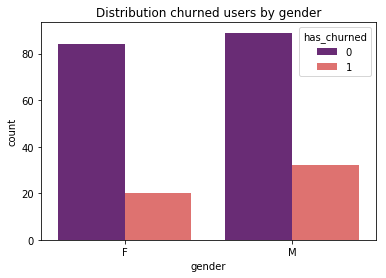

Churn rate in dataset for female is of: 19%
Churn rate in datasetfor male is of: 26%


In [27]:

q2 = spark.sql('''
        SELECT gender,
        has_cancelled as has_churned,
        userid
        FROM sparkify_users_interactions_churn
    
    group by 1,2,3
''').toPandas()


sns.countplot(x = 'gender', hue = 'has_churned', data = q2, palette = 'magma')
plt.title('Distribution churned users by gender')
plt.show()


# compute churn rate by gender
churn_rate_gender = q2.loc[q2['has_churned'] == 1].groupby('gender')['userid'].count()/ q2.groupby('gender')['userid'].count()

print("Churn rate in dataset for female is of:", "{:.0%}".format(churn_rate_gender[0]))
print("Churn rate in datasetfor male is of:", "{:.0%}".format(churn_rate_gender[1]))


`.` significant difference of churn rate between male and female users. definitely a variable to add to our model

### `3.` Churn rate by level/subscription type


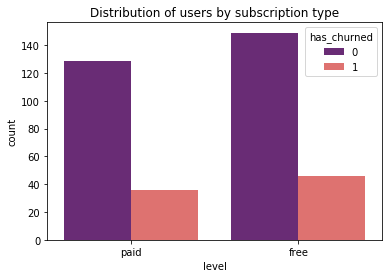

Churn rate in dataset for paid subscription users is of: 24%
Churn rate in datasetfor free subscription users is of: 22%


In [28]:
q3 = spark.sql('''
        SELECT level,
        has_cancelled as has_churned,
        userid
        FROM sparkify_users_interactions_churn
    group by 1,2,3
''').toPandas()


sns.countplot(x = 'level', hue = 'has_churned', data = q3, palette = 'magma')
plt.title('Distribution of users by subscription type')
plt.show()


# compute churn rate by level
churn_rate_level = q3.loc[q3['has_churned'] == 1].groupby('level')['userid'].count()/ q3.groupby('level')['userid'].count()

print("Churn rate in dataset for paid subscription users is of:", "{:.0%}".format(churn_rate_level[0]))
print("Churn rate in datasetfor free subscription users is of:", "{:.0%}".format(churn_rate_level[1]))


`.` surprisingly, one would have expected greater difference between the two group since the latter is served advertising 
that can be considered as "disturbing"

### `4.`Item played in session


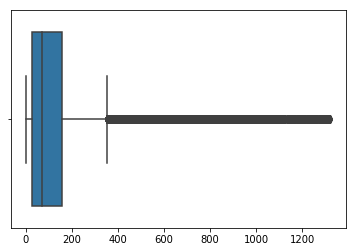

In [29]:
# viz iteminsession
q4 = spark.sql('''
        SELECT iteminsession
        FROM sparkify_users_interactions_churn
        ''').toPandas()


sns.boxplot(q4);

`.` As expected from summary statistics displayed above, distribution of our variable is positively skewed to the right with an average 
of 115 iteminsession but still many users located under value reported as first quartile (27).

`.` New users would probably be "penalised" as counter would necessarly start at 0, this might be misleading for our models.

### `5.` Users's age in platform


In [30]:
# create new column registering diff in days since user signed up
df_clean = df_clean.withColumn("num_days_since_signup", datediff(col("event_timedate"),col("registration_timedate")))


In [31]:
# update table with new col
df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

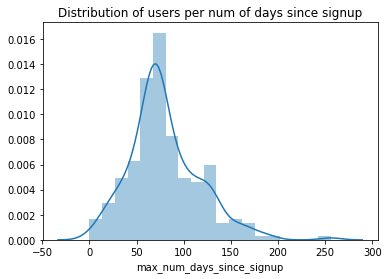

In [32]:
q5 = spark.sql('''
        SELECT DISTINCT userid, MAX(num_days_since_signup) as max_num_days_since_signup
        FROM sparkify_users_interactions_churn
        GROUP BY userid
        
        ''').toPandas()

sns.distplot(q5.max_num_days_since_signup);

plt.title('Distribution of users per num of days since signup')
plt.show()

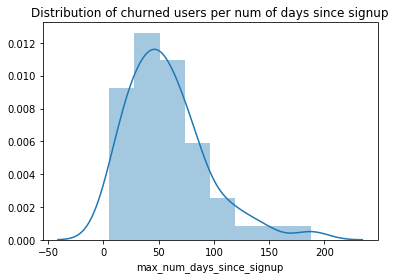

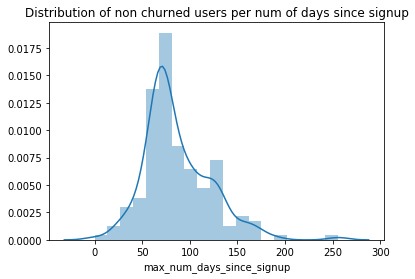

In [33]:
q5 = spark.sql('''
        SELECT DISTINCT userid, MAX(num_days_since_signup) as max_num_days_since_signup
        FROM sparkify_users_interactions_churn
        Where has_cancelled = 1
        GROUP BY userid
        
        ''').toPandas()

sns.distplot(q5.max_num_days_since_signup);

plt.title('Distribution of churned users per num of days since signup')
plt.show()

q6 = spark.sql('''
        SELECT DISTINCT userid, MAX(num_days_since_signup) as max_num_days_since_signup
        FROM sparkify_users_interactions_churn
        Where has_cancelled = 0
        GROUP BY userid
        
        ''').toPandas()

sns.distplot(q6.max_num_days_since_signup);

plt.title('Distribution of non churned users per num of days since signup')
plt.show()

In [34]:
q5.describe()

,userid,max_num_days_since_signup
count,52.000000,52.000000
mean,80808.423077,57.365385
std,86381.677066,36.587809
min,3.000000,5.000000
25%,83.500000,30.500000
50%,100005.500000,51.500000
75%,100023.250000,73.750000
max,300007.000000,188.000000


`.` Interesting how the two distribution difer, one fourth of our churned users did have less than a month of activity in platform. this can be useful to modify some campaigns targeting users acquisition. 


### `7.` Positive interactions in platform


`.` we first need to identify which events/pages should be considered as positive or negative interactions

In [35]:
# Define meaningful positive/negative interactions

positive_experience = ['Add Friend','Add to Playlist','NextSong','Thumbs Up']
negative_experience = ['Error','Submit Downgrade','Thumbs Down','Help']

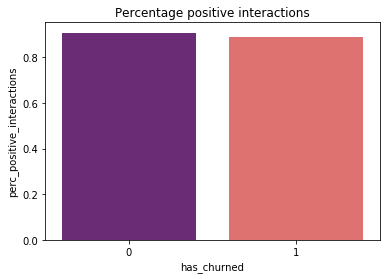

Percentage of positive interactions for non-churned users: 89%
Percentage of positive interactions churned users: 91%


In [36]:
# Percentage of positive & negative interactions for churn

q7 = spark.sql('''
        SELECT has_cancelled as has_churned
                ,(count(case when page in ('Add Friend','Add to Playlist','NextSong','Thumbs Up') then 1 else null end)/ count(*)) as perc_positive_interactions

        FROM sparkify_users_interactions_churn
     group by 1

''').toPandas()


sns.barplot(x = 'has_churned',y='perc_positive_interactions', data = q7, palette = 'magma')
plt.title('Percentage positive interactions')
plt.show()



print("Percentage of positive interactions for non-churned users:", "{:.0%}".format(q7.values[0][1]))
print("Percentage of positive interactions churned users:", "{:.0%}".format(q7.values[1][1]))



`.` Difference between the two groups surprisingly lower than one could expect. we should probably treat each of these interactions individually in our models.

`.` Results are probably due to the fact we are taking into account all interactions/events as total.

### `8.` Location

`.` after identifying all our users in dataset are located in the US, one can see it's possible to extract the state from the location string.

In [37]:
# state placed at the very end of string
get_location_state = udf(lambda x: x[-2:])

df_clean = df_clean.withColumn("state",get_location_state(df_clean.location))


In [38]:
# update table with new col
df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

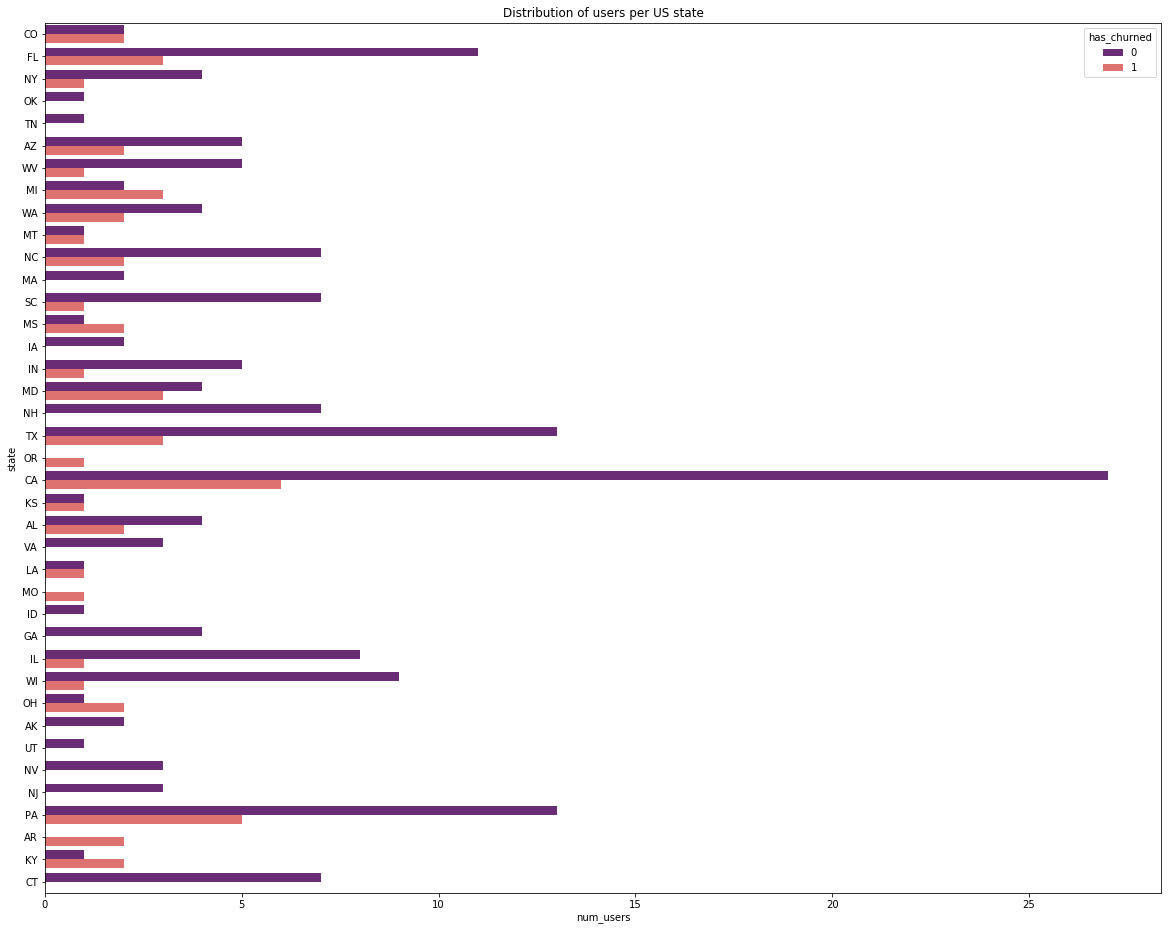

In [39]:

q8 = spark.sql('''
        SELECT has_cancelled as has_churned
                ,state
                ,count(distinct userid) as num_users

        FROM sparkify_users_interactions_churn
     group by 1,2

''').toPandas()


plt.figure(figsize=[20,16])
sns.barplot(x = 'num_users',y='state', hue='has_churned', data = q8, palette = 'magma')
plt.title('Distribution of users per US state')
plt.show()



`.` interesting but will be hard to extract feature out of it. Most of churned are located in FL, PA and TX but those are stated where we account for most of our users.

`.` MI, KY, OH on the other hand have more churned than non-churned. This is interesting.

# <a class="anchor" id="feateng">4. Features engineering</a>


Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- iteminsession: long (nullable = true)
 |-- lastname: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionid: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: integer (nullable = true)
 |-- useragent: string (nullable = true)
 |-- userid: integer (nullable = true)
 |-- event_timedate: string (nullable = true)
 |-- registration_timedate: string (nullable = true)
 |-- has_cancelled: integer (nullable = false)
 |-- has_downgraded: integer (nullable = false)
 |-- num_days_since_signup: integer (nullable = true)
 |-- state: string (nullable = true)



### 1. String indexer

`.` StringIndexer encodes a string column of labels to a column of label indices. The indices are ordered by label frequencies. Most frequent label gets index 0, see [here](https://spark.apache.org/docs/1.4.1/ml-features.html#stringindexer)     

In [41]:
# String indexer
SI_gender = StringIndexer(inputCol='gender',outputCol='gender_index')
SI_level = StringIndexer(inputCol='level',outputCol='level_index')
SI_auth = StringIndexer(inputCol='auth',outputCol='auth_index')
SI_state = StringIndexer(inputCol='state',outputCol='state_index')
#SI_page = StringIndexer(inputCol='page',outputCol='page_index')

In [42]:
df_clean = SI_gender.fit(df_clean).transform(df_clean)
df_clean = SI_level.fit(df_clean).transform(df_clean)
df_clean = SI_auth.fit(df_clean).transform(df_clean)
df_clean = SI_state.fit(df_clean).transform(df_clean)
#df_clean = SI_page.fit(df_clean).transform(df_clean)

In [43]:
df_clean.toPandas().head()

,artist,auth,firstname,gender,iteminsession,lastname,length,level,location,method,...,event_timedate,registration_timedate,has_cancelled,has_downgraded,num_days_since_signup,state,gender_index,level_index,auth_index,state_index
0,The Offspring,Logged In,Natalee,F,0,Charles,168.30649,paid,"Raleigh, NC",PUT,...,2018-10-27 16:44:43,2018-09-13 00:49:30,0,1,44,NC,0.0,0.0,0.0,5.0
1,Slakah the Beatchild Feat. Drake,Logged In,Natalee,F,1,Charles,227.00363,paid,"Raleigh, NC",PUT,...,2018-10-27 16:47:31,2018-09-13 00:49:30,0,1,44,NC,0.0,0.0,0.0,5.0
2,Paramore,Logged In,Natalee,F,2,Charles,209.42322,paid,"Raleigh, NC",PUT,...,2018-10-27 16:51:18,2018-09-13 00:49:30,0,1,44,NC,0.0,0.0,0.0,5.0
3,ManÃÂ¡,Logged In,Natalee,F,3,Charles,307.72200,paid,"Raleigh, NC",PUT,...,2018-10-27 16:54:47,2018-09-13 00:49:30,0,1,44,NC,0.0,0.0,0.0,5.0
4,Taylor Swift,Logged In,Natalee,F,4,Charles,238.99383,paid,"Raleigh, NC",PUT,...,2018-10-27 16:59:54,2018-09-13 00:49:30,0,1,44,NC,0.0,0.0,0.0,5.0


### 2. One hot encoder

In [44]:

OHE = OneHotEncoder(inputCol='gender_index',outputCol='gender_ohe')
df_clean = OHE.transform(df_clean)

OHE = OneHotEncoder(inputCol='level_index',outputCol='level_ohe')
df_clean = OHE.transform(df_clean)

OHE = OneHotEncoder(inputCol='auth_index',outputCol='auth_ohe')
df_clean = OHE.transform(df_clean)

OHE = OneHotEncoder(inputCol='state_index',outputCol='state_ohe')
df_clean = OHE.transform(df_clean)


#OHE = OneHotEncoder(inputCol='page_index',outputCol='page_ohe')
#df_clean = OHE.transform(df_clean)


In [45]:
df_clean.toPandas().head()

,artist,auth,firstname,gender,iteminsession,lastname,length,level,location,method,...,num_days_since_signup,state,gender_index,level_index,auth_index,state_index,gender_ohe,level_ohe,auth_ohe,state_ohe
0,The Offspring,Logged In,Natalee,F,0,Charles,168.30649,paid,"Raleigh, NC",PUT,...,44,NC,0.0,0.0,0.0,5.0,(1.0),(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,Slakah the Beatchild Feat. Drake,Logged In,Natalee,F,1,Charles,227.00363,paid,"Raleigh, NC",PUT,...,44,NC,0.0,0.0,0.0,5.0,(1.0),(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,Paramore,Logged In,Natalee,F,2,Charles,209.42322,paid,"Raleigh, NC",PUT,...,44,NC,0.0,0.0,0.0,5.0,(1.0),(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,ManÃÂ¡,Logged In,Natalee,F,3,Charles,307.72200,paid,"Raleigh, NC",PUT,...,44,NC,0.0,0.0,0.0,5.0,(1.0),(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,Taylor Swift,Logged In,Natalee,F,4,Charles,238.99383,paid,"Raleigh, NC",PUT,...,44,NC,0.0,0.0,0.0,5.0,(1.0),(1.0),(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [46]:
# update table with new col
df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

In [47]:
# drop cols
#cols = ["artist","length","firstname","lastname", "length","location","method","registration","song","status"]

In [48]:
#df_clean_model_features = df_clean.drop(*cols)

In [92]:
features_df = spark.sql('''
        SELECT
         userid
        ,has_cancelled as label
        
        -- encoded
        ,gender_ohe
        ,state_ohe
        -- ,level_ohe
        -- ,page_ohe
        
        -- num variables
        ,max(auth_index) as max_auth_index
        ,max(level_index) as max_level_index
        ,max(has_downgraded) as max_has_downgraded
        ,max(num_days_since_signup) as max_num_days_since_signup
        ,count(distinct sessionid) as num_sessions
        ,count(*) as num_total_interactions
        ,count(case when page in ('Add Friend','Add to Playlist','NextSong','Thumbs Up') then 1 else null end) as num_positive_interactions
        ,count(case when page in ('Error','Submit Downgrade','Thumbs Down','Help') then 1 else null end) as num_negative_interactions
        
        FROM sparkify_users_interactions_churn
    group by 1,2,3,4
  
''')

In [93]:
features_df.toPandas().head(3)

,userid,label,gender_ohe,state_ohe,max_auth_index,max_level_index,max_has_downgraded,max_num_days_since_signup,num_sessions,num_total_interactions,num_positive_interactions,num_negative_interactions
0,156,0,(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,0,0,1,6,3,0
1,74,0,(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,1,71,23,2887,2658,40
2,300009,0,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,1,101,18,1721,1624,24


In [94]:
# check # of rows/users
print((features_df.count(), len(features_df.columns)))

(225, 12)


# <a class="anchor" id="model">5. Modeling</a>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

`.` We managed to extract interesting features from variables in our dataset. Next step is now to train and evaluate various models.
We'll proceed with the following two algorithms as they are robust and well designed for classification problem

1.Logistic Regression, [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html)

2.Random Forest Classifier, [here](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html)

In [95]:
# update table with added features
features_df.createOrReplaceTempView("sparkify_churn_model_features")

In [96]:
# check datatype of our features
features_df.printSchema()

root
 |-- userid: integer (nullable = true)
 |-- label: integer (nullable = false)
 |-- gender_ohe: vector (nullable = true)
 |-- state_ohe: vector (nullable = true)
 |-- max_auth_index: double (nullable = true)
 |-- max_level_index: double (nullable = true)
 |-- max_has_downgraded: integer (nullable = true)
 |-- max_num_days_since_signup: integer (nullable = true)
 |-- num_sessions: long (nullable = false)
 |-- num_total_interactions: long (nullable = false)
 |-- num_positive_interactions: long (nullable = false)
 |-- num_negative_interactions: long (nullable = false)



### Step 1. Features as Vectors

`.` Create a vector from the combined columns of all of the features, see [here](https://spark.apache.org/docs/1.4.1/ml-features.html#vectorassembler)

VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. 
In each row, the values of the input columns will be concatenated into a vector in the specified order.

In [97]:
assembler = VectorAssembler(inputCols = ["gender_ohe","state_ohe", "max_level_index", "max_auth_index","max_num_days_since_signup","num_sessions","num_total_interactions","num_positive_interactions","num_negative_interactions"],outputCol = "features_vec")

features_df = assembler.transform(features_df)

### Step 2. Features Standardisation

`.`StandardScaler transforms a dataset of Vector rows, see [here](https://spark.apache.org/docs/1.4.1/ml-features.html#standardscaler)
                                                                  
Normalizing each feature to have unit standard deviation and/or zero mean.
This can be relevant to our model since we are dealing with features of different scale and do not necessarly want highest/lowest values to overweight in the model predictions.


In [98]:
scaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True)

scaler_model = scaler.fit(features_df)

features_df = scaler_model.transform(features_df)


In [99]:
features_df.toPandas().head()

,userid,label,gender_ohe,state_ohe,max_auth_index,max_level_index,max_has_downgraded,max_num_days_since_signup,num_sessions,num_total_interactions,num_positive_interactions,num_negative_interactions,features_vec,features
0,156,0,(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,0,0,1,6,3,0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 3.67784856245, 0.0, 0.0, 0.0, 0.0, ..."
1,74,0,(1.0),"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,1,71,23,2887,2658,40,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(2.00127105192, 0.0, 0.0, 0.0, 0.0, 4.13057034..."
2,300009,0,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,1,101,18,1721,1624,24,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.00127105192, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,138,0,(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,1,66,15,2469,2273,38,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 3.67784856245, 0.0, 0.0, 0.0, 0.0, ..."
4,86,0,(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0,1,135,10,818,722,17,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 4.13057034493, 0.0, ..."


### Step 3. Train Test Split

In [100]:
# split dataset into train/test/validation datasets

train, test, valid = features_df.randomSplit([0.6, 0.2, 0.2], seed = 42)

print("Size train dataset:" + str(train.count()))
print("Size test Dataset:" + str(test.count()))
print("Size validation Dataset:" + str(valid.count()))

Size train dataset:135
Size test Dataset:38
Size validation Dataset:52


In [101]:
# instantiate models

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rfc = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=42)


In [102]:
# list of models to train/test
model_list = [lr,rfc]


In [103]:
# used to evaluate our classification modeles
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')


In [110]:
# Execute train/predictions and eval of our models
for model in model_list:
    
    model_name = model.__class__.__name__
    
    print(model_name, 'training started')
    
    # training starts
    start = time.time()
    
    # fit the model on training data
    model = model.fit(train)
    
    # training finished
    end = time.time()
     
    print(model_name, 'training completed')
    
    # training exec time length
    print('Time taken for training {} is:'.format(model_name),(end-start),'seconds')
    
    # predictions start
    print(model_name, 'predictions started')
    
    predictions = model.transform(valid)
    
    print(model_name, 'predictions completed')
    
    # evaluate models using accuracy and f1 score:
    
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    
    print("The accuracy of the {} model is:".format(model_name), accuracy)

    

LogisticRegression training started
LogisticRegression training completed
Time taken for training LogisticRegression is: 92.05986475944519 seconds
LogisticRegression predictions started
LogisticRegression predictions completed
F1 for LogisticRegression is: 0.9630036630036631
The accuracy of the LogisticRegression model is: 0.9615384615384616
RandomForestClassifier training started
RandomForestClassifier training completed
Time taken for training RandomForestClassifier is: 125.2970678806305 seconds
RandomForestClassifier predictions started
RandomForestClassifier predictions completed
F1 for RandomForestClassifier is: 1.0
The accuracy of the RandomForestClassifier model is: 1.0


### Step 4. Model tuning 



`.` Both models return pretty satisfying results. In the end we will probably end up using RandomForestClassifier as it delivers
the best outcome for both accurancy and F1 even though it probably requires more computational power (40% more time to execute).

`.` Given the performance issue and the risk of overfitting due to the low number of users used in training, we'll see to improve
a bit our already good model results.

`Maxdepth`: set a max of 15 to reduce risk of overfitting

`Numfolds`: reduced to 3 instead of 5 to reduce execution time in training

In [ ]:
# gridsearch params

params= ParamGridBuilder() \
    .addGrid(rfc.maxDepth,[5, 10, 15]) \
    .build()


cross_val = CrossValidator(estimator=rfc,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

# fit train dataset
cross_val_model = cross_val.fit(train)



In [105]:
results = cross_val_model.transform(valid)
accuracy = results.filter(results.label == results.prediction).count() / (results.count())
best_model = cross_val_model.bestModel

print ("Best Param value for MaxDepth: ", best_model._java_obj.getMaxDepth())
print('F1-score for best model:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print('Accuracy for best model:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))


Best Param value for MaxDepth:  10
F1-score for best model: 1.0
Accuracy for best model: 1.0


# <a class="anchor" id="results">6. Conclusion</a>

`.` Wrapping up the project. We were assigned the task to deliver a predictive model aiming at identifying but then preventing users to churn, given the cost related to users acquisition.

`.`We had access to a small dataset (128MB) gathering clickstream data for 225 unique users.
After cleaning our dataset, exploring possible variables of interest to identify churned/non-churned users, we had the chance to transform those variables into features we would then use into our models.

`.`Using various techniques, we were able to integrate most of our desired variables, then carry on with training two models we selected for their good performances when dealing with classification problem.

`.`Both models were trained and evaluated against provided dataset. As noted along the exploratory analysis, the class we are trying to predict is unbalanced therefore f1-score had to be computed as such scenario may lead
to unreliable accuracy score.

`.`Also, since we are dealing with a small dataset, training is done on with relatively low number of users and may have an impact (i.e overfitting) therefore, we tuned our best model and would end up using a `maxDepth` param of 10 and when it comes to performance, reduce the `numFolds` to 3 instead of 5 initially.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.